## Here we will build an parallel work flow 

In [20]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict , Annotated
from dotenv import load_dotenv
from pydantic import BaseModel,Field
import operator

In [21]:
load_dotenv()

llm=ChatGoogleGenerativeAI(
model="gemini-2.5-flash",
)

E0000 00:00:1760383972.208807  343050 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [22]:
class EvaluationSchema(BaseModel):
    feedback:str =Field(description='Detailed feedback for the eassay')
    score:int =Field(descriptions="Score out of 10" ,ge=0,le=10)

/var/folders/qh/dr4cc0hn7wvcwzcv1j5zfjf40000gn/T/ipykernel_15288/1877820463.py:3: PydanticDeprecatedSince20: Using extra keyword arguments on `Field` is deprecated and will be removed. Use `json_schema_extra` instead. (Extra keys: 'descriptions'). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  score:int =Field(descriptions="Score out of 10" ,ge=0,le=10)


In [23]:
structured_llm=llm.with_structured_output(EvaluationSchema)

In [24]:
essay="""
 The Journey of AI in India: A Simple Overview

India's relationship with Artificial Intelligence (AI) has rapidly transformed over the past few decades, moving from a niche academic field to a core national mission.

In the **early days (1960s-1990s)**, AI was primarily studied in elite institutions like the IITs and IISc. The focus was on basic research, often struggling with limited computer power. It was an era of foundations and slow progress.

The 21st century** brought the breakthrough. India's booming IT industry and its massive "Digital Public Infrastructure" (like Aadhaar and UPI) provided a vast, real-world testing ground for AI. This led to a surge in AI applications for business automation, customer service, and finance. Bengaluru became a major hub, attracting global companies and spawning thousands of local AI startups.

Today, AI in India is a national priority, guided by the government's **IndiaAI Mission**. This strategy is focused on using AI to solve India's unique social challenges. The government is investing heavily in building local AI supercomputers (GPUs), creating high-quality datasets in Indian languages, and developing India-specific AI models like **BharatGen AI** and the language platform **Bhashini**. The goal is clear: to ensure AI is "Made in India" and "Works for India," transforming crucial sectors like healthcare, agriculture, and education to benefit the entire population. India is now aiming to be a global leader in creating inclusive and responsible AI.
"""



In [25]:
prompt=f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 In {essay}"

structured_llm.invoke(prompt)


EvaluationSchema(feedback="The essay provides a clear and concise overview of AI's journey in India. The language is accessible and easy to understand, making complex information digestible for a general audience. The use of bold text effectively highlights key periods and initiatives. The flow is logical, moving from historical context to current national priorities and future aspirations. There are no significant grammatical errors or awkward phrasings. The vocabulary is appropriate and contributes to the professional yet engaging tone. Overall, the language quality is excellent, successfully conveying the intended message with clarity and impact.", score=9)

In [26]:
class EssayState(TypedDict):
    essay:str
    language_feedback:str 
    depth_of_analysis_feedback:str
    clarity_of_thoughts:str
    overall_feedback:str
    individual_score: Annotated[list[int],operator.add]
    avg_score:float 
    

In [27]:
def evaluate_langchain(state:EssayState)->EssayState:
    prompt=f"Evaluate the depth analysis of the following essay and provide a feedback and assign a score out of 10 In {state['essay']}"
    output=structured_llm.invoke(prompt)
    return {
        'depth_of_analysis_feedback':output.feedback,
        'individual_score':[output.score]
    }

In [28]:
def evaluate_depth_of_analysis_feedback(state:EssayState)->EssayState:
    prompt=f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 In {state['essay']}"
    output=structured_llm.invoke(prompt)
    return {
        'language_feedback':output.feedback,
        'individual_score':[output.score]
    }

In [29]:
def evaluate_clarity_of_thoughts(state:EssayState)->EssayState:
    prompt=f"Evaluate the clarity of thoughts of the following essay and provide a feedback and assign a score out of 10 In {state['essay']}"
    output=structured_llm.invoke(prompt)
    return {
        'clarity_of_thoughts':output.feedback,
        'individual_score':[output.score]
    }

In [41]:
def final_evalutions(state:EssayState)->EssayState:
    prompt=f"Based on the following feedbacks create a summarized feedback \n  langauage_feedback: {state['language_feedback']}  \n depth_of_analysis_feedback: {state['depth_of_analysis_feedback']}  \n clarity_of_thoughts: {state['clarity_of_thoughts']}  \n   "
    output=structured_llm.invoke(prompt)

    avg=sum(state['individual_score'])/len(state['individual_score'])
    return {
        'overall_feedback':output.feedback,
        'avg_score':[output.score]
    }

In [42]:
graph=StateGraph(EssayState)

graph.add_node('evaluate_langauge',evaluate_langchain)
graph.add_node('evaluate_depth_of_analysis_feedback',evaluate_depth_of_analysis_feedback)
graph.add_node('evaluate_clarity_of_thoughts',evaluate_clarity_of_thoughts)
graph.add_node('final_evalutions',final_evalutions)


#adding edges 

graph.add_edge(START,'evaluate_langauge')
graph.add_edge(START,'evaluate_depth_of_analysis_feedback')
graph.add_edge(START,'evaluate_clarity_of_thoughts')

graph.add_edge('evaluate_langauge','final_evalutions')
graph.add_edge('evaluate_depth_of_analysis_feedback','final_evalutions')
graph.add_edge('evaluate_clarity_of_thoughts','final_evalutions')

workflow=graph.compile()


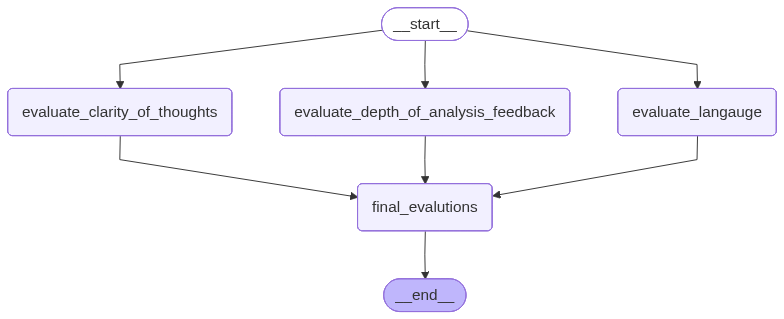

In [39]:
workflow

In [43]:
intial_state={
    'essay':essay,
}

ans=workflow.invoke(intial_state)
print(ans)

{'essay': '\n The Journey of AI in India: A Simple Overview\n\nIndia\'s relationship with Artificial Intelligence (AI) has rapidly transformed over the past few decades, moving from a niche academic field to a core national mission.\n\nIn the **early days (1960s-1990s)**, AI was primarily studied in elite institutions like the IITs and IISc. The focus was on basic research, often struggling with limited computer power. It was an era of foundations and slow progress.\n\nThe 21st century** brought the breakthrough. India\'s booming IT industry and its massive "Digital Public Infrastructure" (like Aadhaar and UPI) provided a vast, real-world testing ground for AI. This led to a surge in AI applications for business automation, customer service, and finance. Bengaluru became a major hub, attracting global companies and spawning thousands of local AI startups.\n\nToday, AI in India is a national priority, guided by the government\'s **IndiaAI Mission**. This strategy is focused on using AI 